In [1]:
# import necessary packages
import cv2
import numpy as np
from glob import glob
import matplotlib.pylab as plt
from sklearn.cross_validation import train_test_split
from sklearn import preprocessing
from keras.utils import np_utils
import collections
from skimage.transform import rotate
from skimage import img_as_ubyte
import pandas as pd
%matplotlib inline

/home/weili/virts/tensorflow_gpu/local/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
Using TensorFlow backend.
/home/weili/virts/tensorflow_gpu/local/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# 1. Data Exploration and Visualization

In [2]:
### read image path
all_files = glob("../train/*/*.png")
print "number of files is: {}".format(len(all_files))

number of files is: 4750


In [3]:
### calculate the number of images for each category
all_files_category = [c.split('/')[-2] for c in all_files]
collections.Counter(all_files_category)

Counter({'Black-grass': 263,
         'Charlock': 390,
         'Cleavers': 287,
         'Common Chickweed': 611,
         'Common wheat': 221,
         'Fat Hen': 475,
         'Loose Silky-bent': 654,
         'Maize': 221,
         'Scentless Mayweed': 516,
         'Shepherds Purse': 231,
         'Small-flowered Cranesbill': 496,
         'Sugar beet': 385})

In [14]:
category_list = ['Black-grass', 
                 'Charlock', 
                 'Cleavers',
                 'Common Chickweed',
                 'Common wheat',
                 'Fat Hen',
                 'Loose Silky-bent',
                 'Maize',
                 'Scentless Mayweed',
                 'Shepherds Purse',
                 'Small-flowered Cranesbill',
                 'Sugar beet']
category_count = [263, 390, 287, 611, 221, 475, 654, 221, 516, 231, 496, 385]

In [66]:
### show several images for each category
def display_image(category_name):
    file_cat = [d for d in all_files if d.split('/')[-2] == category_name]
    plt.figure(figsize=(20,20))
    for i in range(4):
        img = cv2.imread(file_cat[i])
        b, g, r = cv2.split(img)
        img_rgb = cv2.merge((r,g,b))
        plt.subplot(1,4,i+1)
        plt.imshow(img_rgb)
        plt.title(category_name)

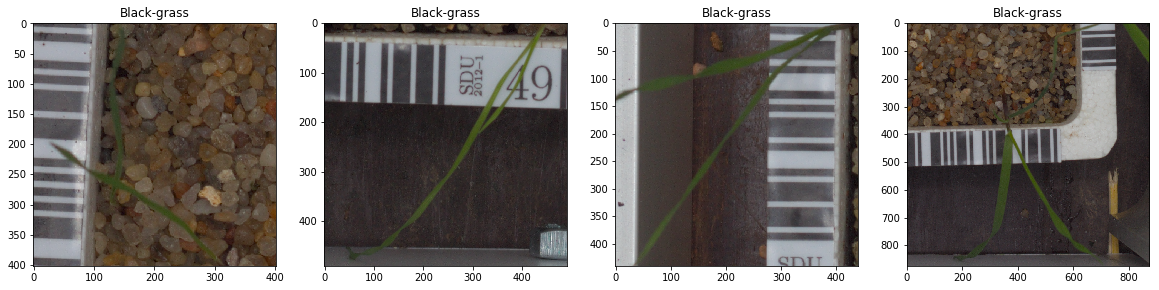

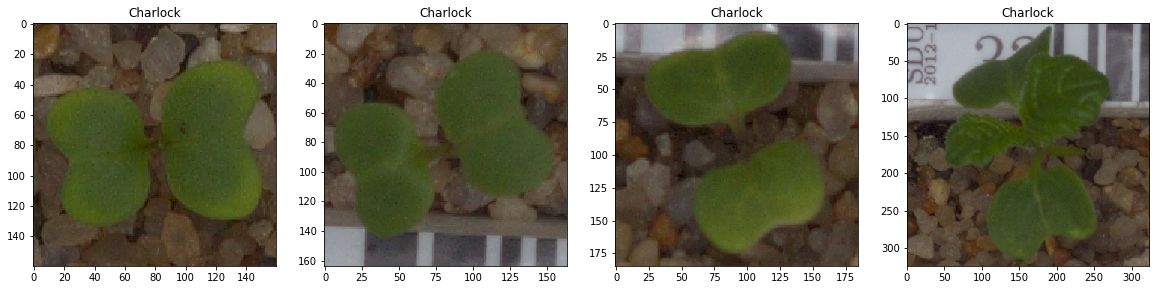

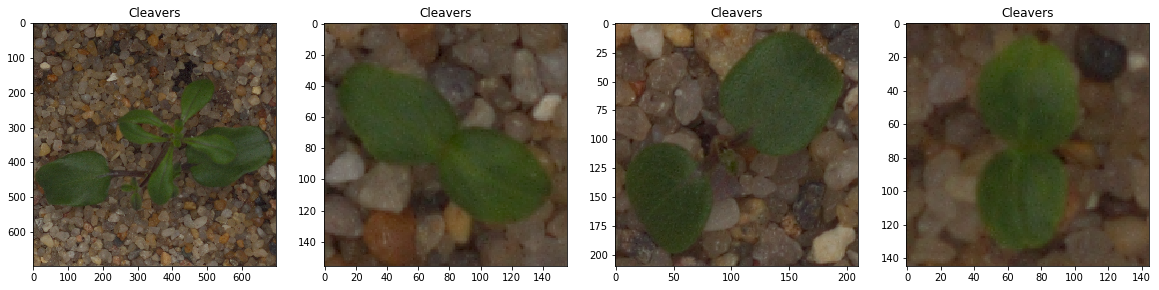

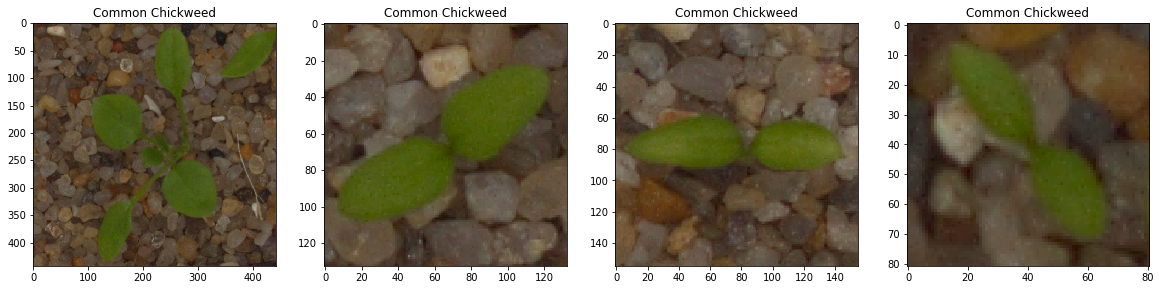

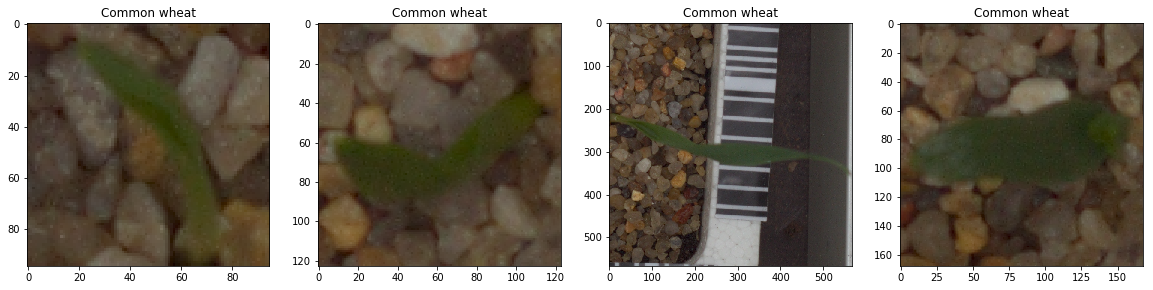

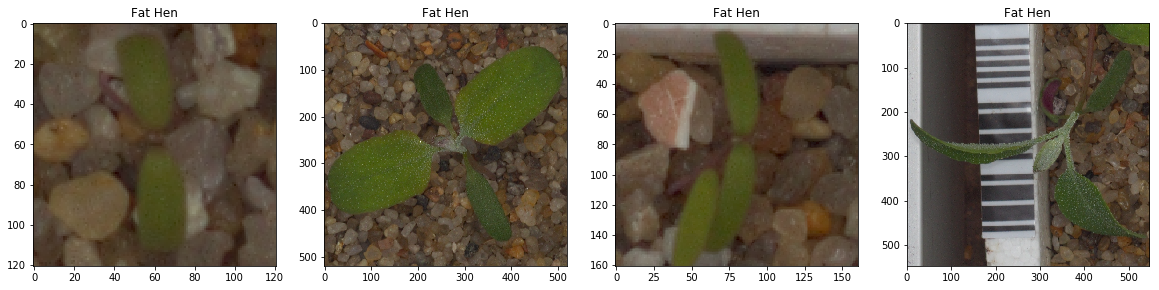

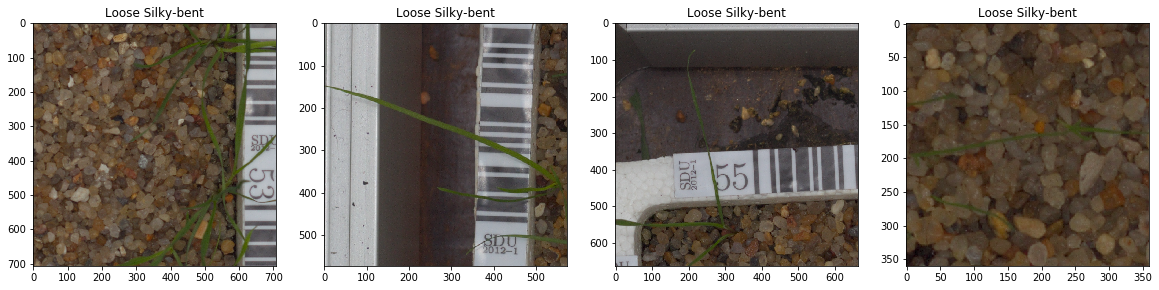

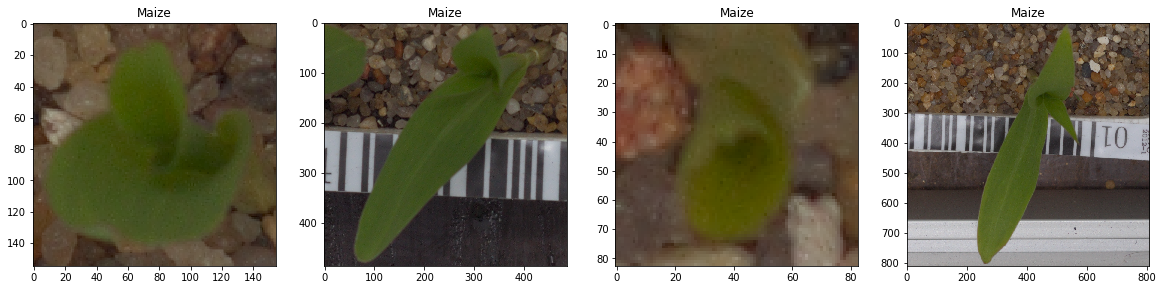

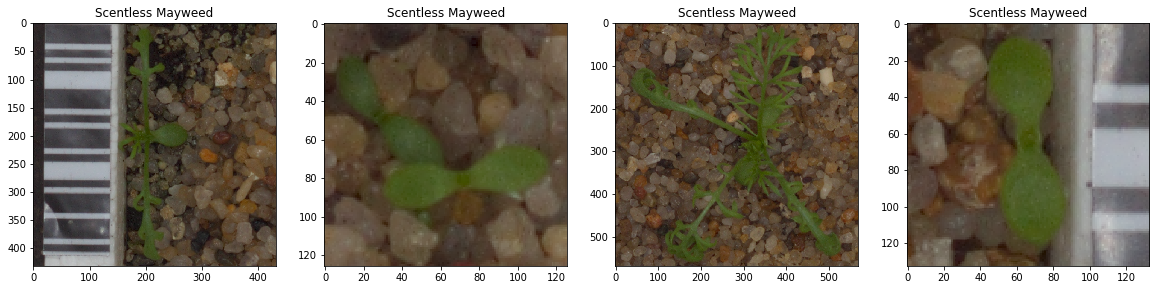

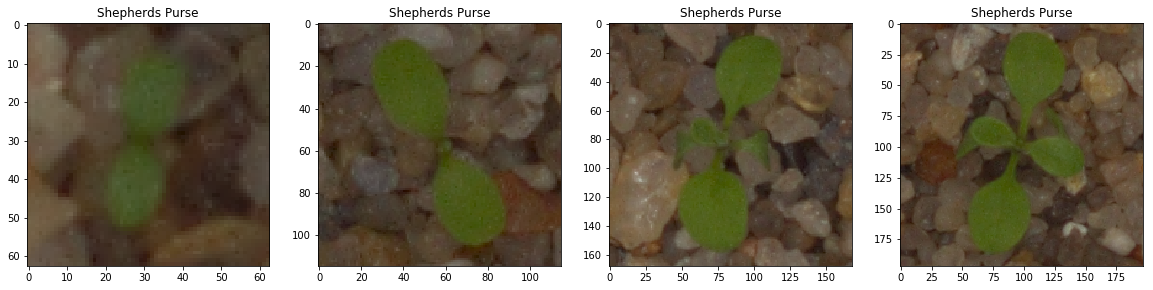

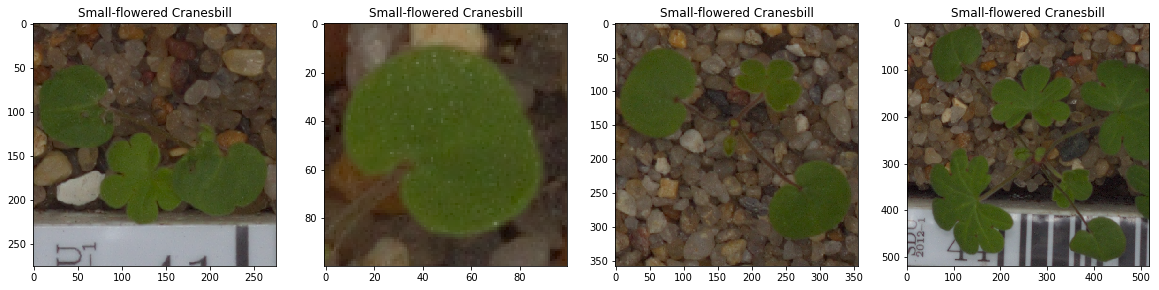

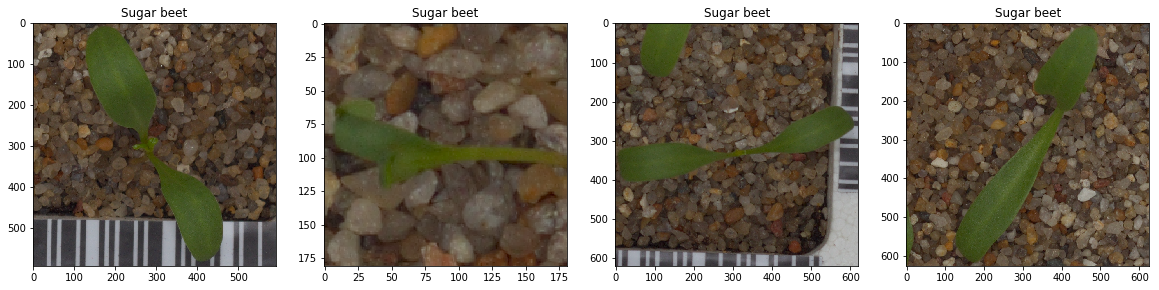

In [6]:
for cat in category_list:
    display_image(cat)

In [16]:
### read pixel for image directory
def read_pixel(dirs):
    pixel = []
    label = []
    ID = []
    
    for d in dirs:
        ID.append(d.split("/")[-1][:-4])
        label.append(d.split("/")[-2])
        pixel.append(cv2.imread(d))
    return np.array(pixel), np.array(label), np.array(ID)

In [17]:
%time pixel, label, ID = read_pixel(all_files)

CPU times: user 31.7 s, sys: 1.94 s, total: 33.6 s
Wall time: 1min 2s


In [67]:
### check image ID
ID = pd.DataFrame(ID)
ID.describe()

0
count        4750
unique       4750
top     18387e60f
freq            1

Text(0.5,1,'Scatter plot for image size')

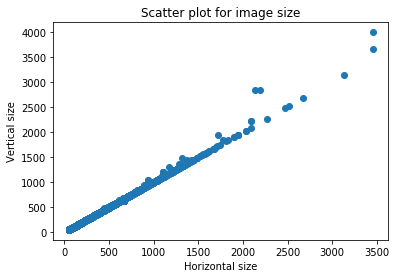

In [51]:
### sactter plot for image size x*y
plt.scatter([im.shape[0] for im in pixel], [im.shape[1] for im in pixel])
plt.xlabel('Horizontal size')
plt.ylabel('Vertical size')
plt.title('Scatter plot for image size')

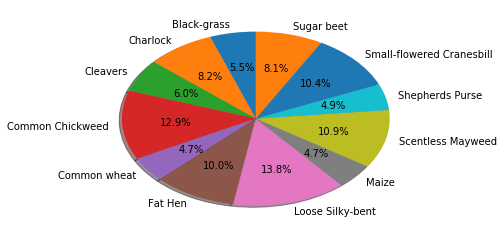

In [56]:
### pie chart for each class
_= plt.pie(category_count, labels= category_list, autopct='%1.1f%%', shadow=True, startangle=90)

In [29]:
### compute mean, std, plot the histogram of pixel for each class
def compute_class_stats(pixel, label, target_class):
    pixel_class = pixel[label == target_class]
    hists = {}
    
    plt.figure(figsize=(20,4))
    plt.subplot(1,3,1)
    plt.hist(
        np.hstack(np.array([im[:,:,0].flatten() for im in pixel_class])), 
        bins=256, color="blue")
    plt.title("Blue channel for {}".format(target_class))
    plt.ylabel("Count")
    plt.xlabel("Pixel intensity")
    
    plt.subplot(1,3,2)
    plt.hist(
        np.hstack(np.array([im[:,:,1].flatten() for im in pixel_class])), 
        bins=256, color="green")
    plt.title("Green channel for {}".format(target_class))
    plt.ylabel("Count")
    plt.xlabel("Pixel intensity")
    
    plt.subplot(1,3,3)
    plt.hist(
        np.hstack(np.array([im[:,:,2].flatten() for im in pixel_class])), 
        bins=256, color="red")
    plt.title("Red channel for {}".format(target_class))
    plt.ylabel("Count")
    plt.xlabel("Pixel intensity")
    
    pixel_class = np.array([im.flatten() for im in pixel_class])
    pixel_class = np.hstack(pixel_class)
    return np.std(pixel_class), np.mean(pixel_class), hists

Processing  Black-grass
Processing  Charlock
Processing  Cleavers
Processing  Common Chickweed
Processing  Common wheat
Processing  Fat Hen
Processing  Loose Silky-bent
Processing  Maize
Processing  Scentless Mayweed
Processing  Shepherds Purse
Processing  Small-flowered Cranesbill
Processing  Sugar beet


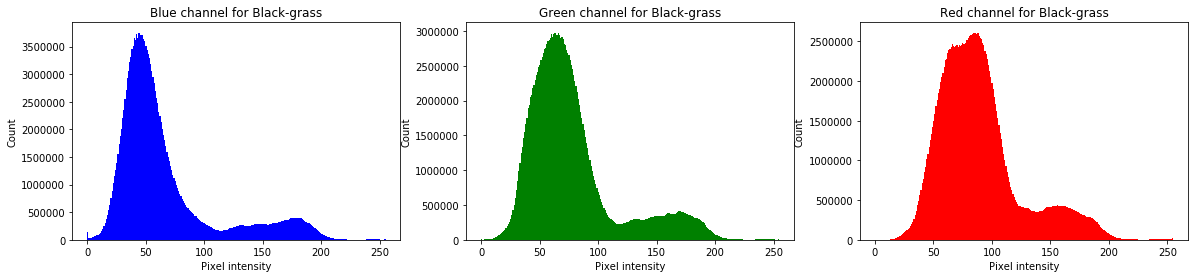

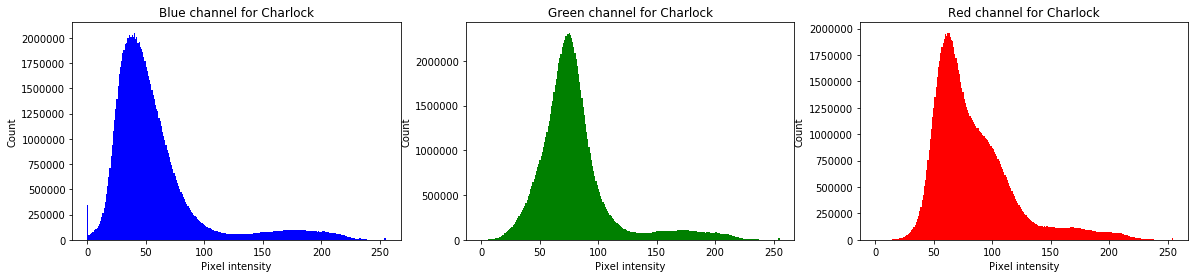

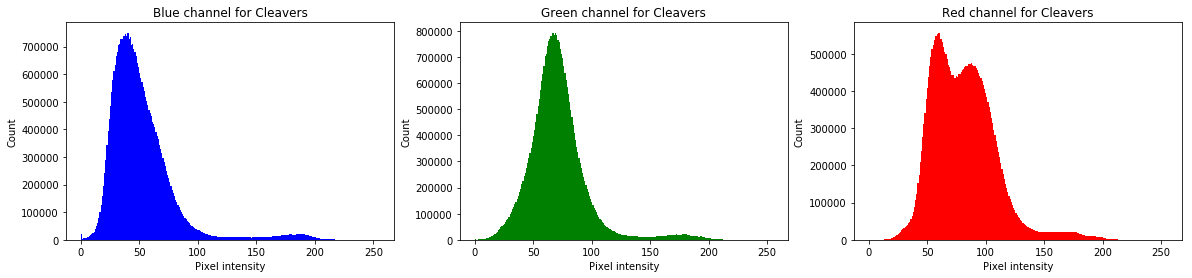

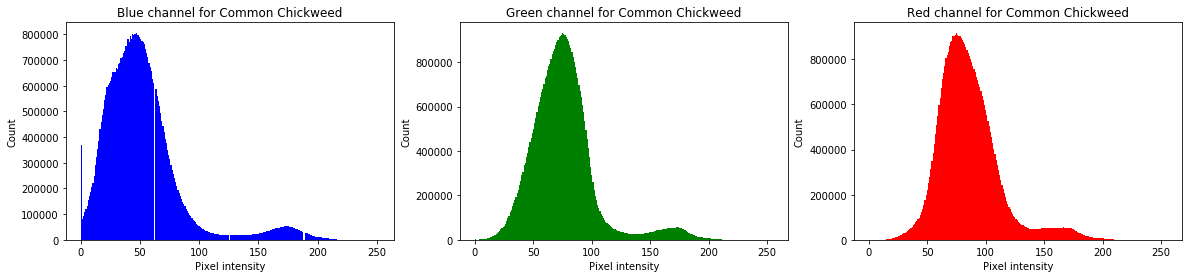

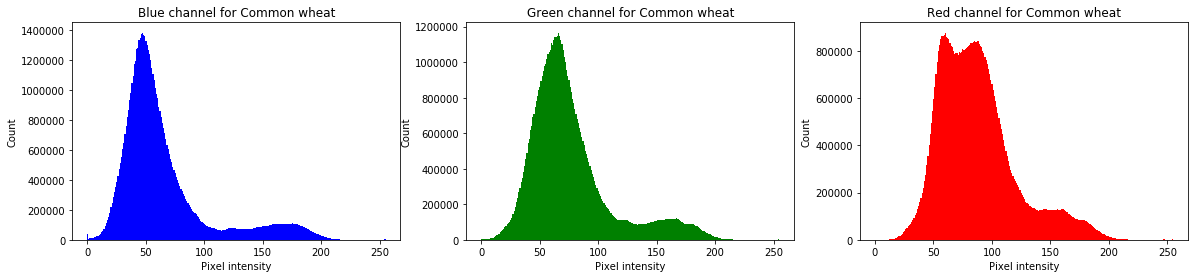

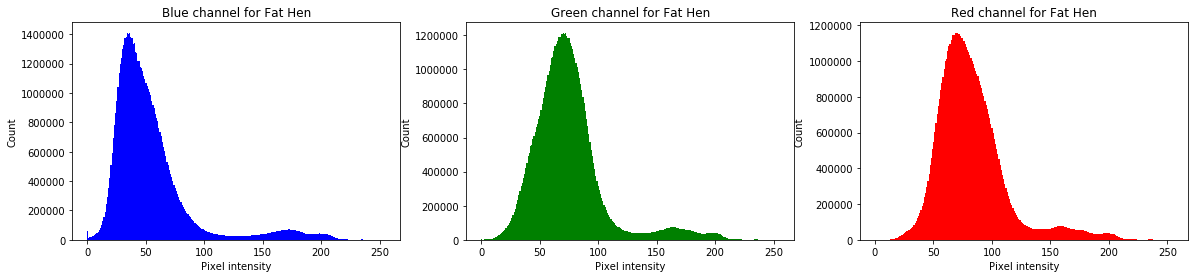

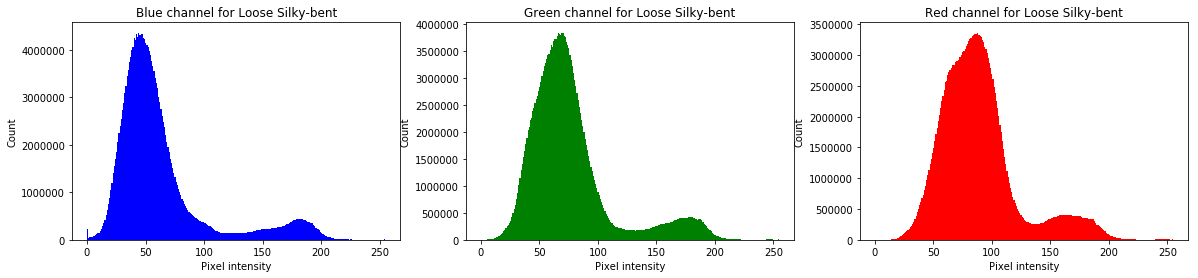

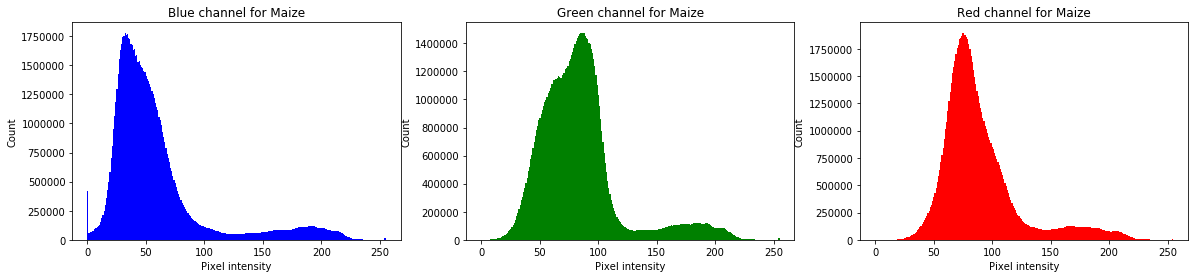

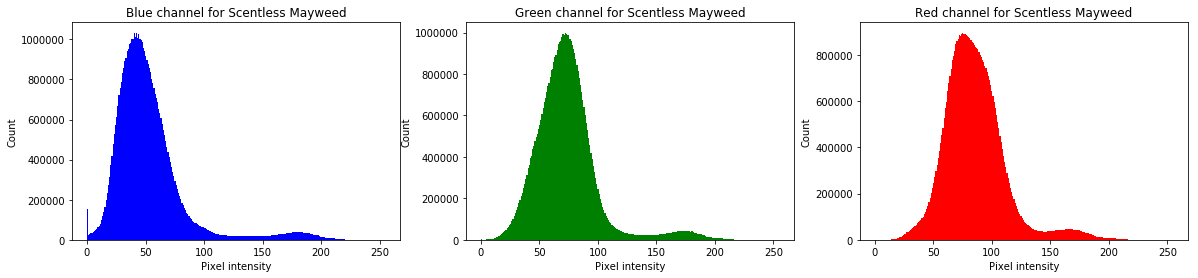

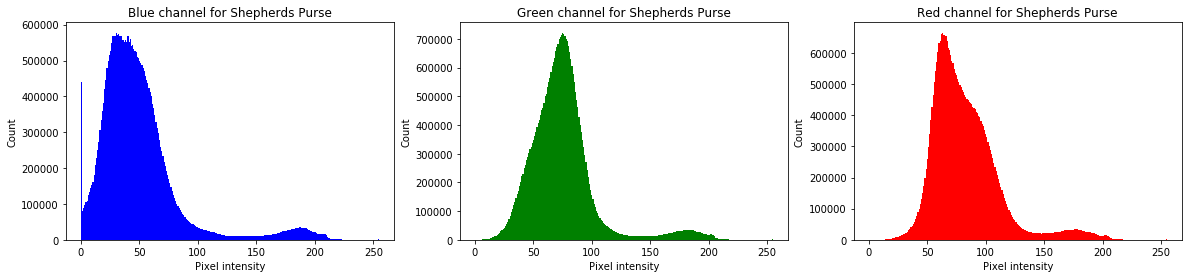

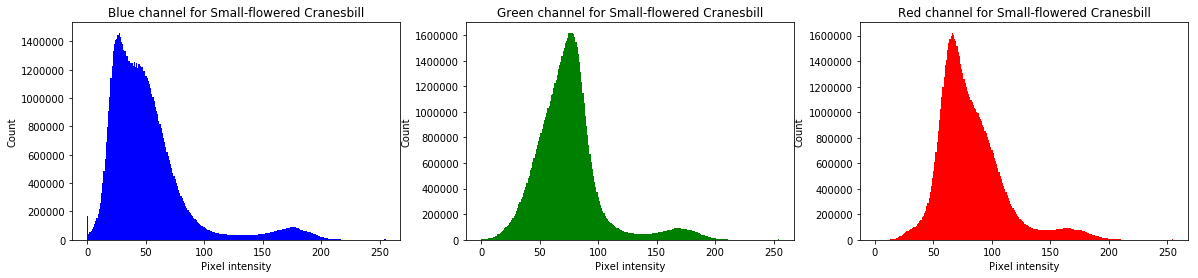

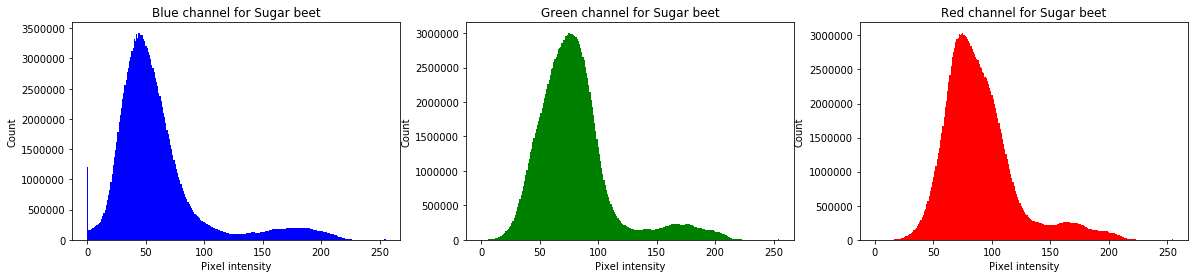

In [30]:
stats_class = []
i = 0
for target_class in category_list:
    print "Processing ", target_class
    class_std, class_mean, class_hist = compute_class_stats(pixel, label, target_class)
    stats_class.append({"class":target_class, "image_count": category_count[i], "pixel_std": class_std, "pixel_mean": class_mean})
    i += 1

In [35]:
pd.DataFrame(stats_class)

class  image_count  pixel_mean  pixel_std
0                 Black-grass          263   77.779325  40.436122
1                    Charlock          390   73.645299  37.926769
2                    Cleavers          287   67.900005  29.910276
3            Common Chickweed          611   71.184007  33.093964
4                Common wheat          221   76.411402  37.324101
5                     Fat Hen          475   70.597564  34.639269
6            Loose Silky-bent          654   76.101788  38.784247
7                       Maize          221   77.352617  39.962530
8           Scentless Mayweed          516   70.533651  31.626891
9             Shepherds Purse          231   69.196591  34.802139
10  Small-flowered Cranesbill          496   69.462099  33.864823
11                 Sugar beet          385   76.595356  36.867444

In [36]:
pd.DataFrame(stats_class).to_csv('stats_class.csv')

# 2. Data Preprocessing

## 2.1 training/validation/testing files splitting

In [4]:
### stratify sampling 
from sklearn.cross_validation import train_test_split
files_train, files_test, files_train_category, files_test_category = train_test_split(all_files, all_files_category, test_size = 0.1, stratify = all_files_category)
files_train, files_valid, files_train_category, files_valid_category = train_test_split(files_train, files_train_category, test_size = 0.2, stratify = files_train_category)

In [5]:
### save dirctory pf train test and validation files, one can load the saved files to reproduce the same results
open('train.txt', 'w').writelines(["%s\n" % item  for item in files_train])
open('test.txt', 'w').writelines(["%s\n" % item  for item in files_test])
open('valid.txt', 'w').writelines(["%s\n" % item  for item in files_valid])

In [6]:
print "number of train_files is: {}".format(len(files_train))
print "number of valid_files is: {}".format(len(files_valid))
print "number of test_files is: {}".format(len(files_test))

number of train_files is: 3420
number of valid_files is: 855
number of test_files is: 475


## 2.2 obtain image input tensor, label, image ID

In [7]:
def preprocess(directory):
    """
    Read and preprocess image of given directory
    """
    im = cv2.imread(directory)
    return cv2.resize(im, (224,224)) # prepare input size for VGG19
    

def format_data(dirs):
    """
    Format data from list of directories
    
    Inputs:
        @dirs: list of directories
    
    Returns:
        @tensor: an numpy array of all images
        @labels: corresponding labels
        @ID: image id
    """
    tensor = []
    label = []
    ID = []
    
    for d in dirs:
        ID.append(d.split("/")[-1][:-4])
        label.append(d.split("/")[-2])
        tensor.append(preprocess(d))
    return np.array(tensor), np.array(label), np.array(ID)

In [8]:
# get the tensor, label, and image ID for train, test, and valid files
%time tensor_train, label_train, ID_train = format_data(files_train)
%time tensor_test, label_test, ID_test = format_data(files_test)
%time tensor_valid, label_valid, ID_valid = format_data(files_valid)

CPU times: user 29.2 s, sys: 1.25 s, total: 30.5 s
Wall time: 1min 6s
CPU times: user 4.47 s, sys: 202 ms, total: 4.68 s
Wall time: 9.65 s
CPU times: user 7.58 s, sys: 310 ms, total: 7.89 s
Wall time: 16.6 s


## 2.3 one hot encoding

In [9]:
def coding_one_hot(df_label):
    le = preprocessing.LabelEncoder().fit(df_label)
    df_label_encoded = le.transform(df_label)
    df_label_one_hot = np_utils.to_categorical(df_label_encoded, 12)
    return df_label_one_hot

In [10]:
### get one-hot codding
train_label_one_hot = coding_one_hot(label_train)
test_label_one_hot = coding_one_hot(label_test)
valid_label_one_hot = coding_one_hot(label_valid)

In [63]:
train_label_one_hot.shape

(3420, 12)

In [64]:
valid_label_one_hot.shape

(855, 12)

In [65]:
test_label_one_hot.shape

(475, 12)

# 3. Benchmark with SVM

In [66]:
### flatten the image metrix
train_flatten = np.array([np.ndarray.flatten(tensor_train[i]) for i in range(tensor_train.shape[0])])
test_flatten = np.array([np.ndarray.flatten(tensor_test[i]) for i in range(tensor_test.shape[0])])
valid_flatten = np.array([np.ndarray.flatten(tensor_valid[i]) for i in range(tensor_valid.shape[0])])

In [67]:
train_flatten.shape

(3420, 150528)

In [68]:
### using PCA for dimension reduction
from sklearn.decomposition import PCA
%time pca = PCA(n_components=1000) # choose 1000 principle components
%time pca.fit(train_flatten)

CPU times: user 13 µs, sys: 3 µs, total: 16 µs
Wall time: 23.8 µs
CPU times: user 52min 12s, sys: 7min 23s, total: 59min 36s
Wall time: 8min 16s


PCA(copy=True, iterated_power='auto', n_components=1000, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

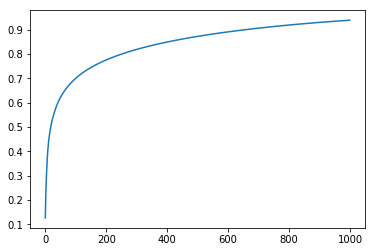

In [69]:
# see the cumulative sum of 1000 principle components
plt.plot(np.cumsum(pca.explained_variance_ratio_))

In [70]:
### pca transform
train_pca = pca.transform(train_flatten)
test_pca = pca.transform(test_flatten)
valid_pca = pca.transform(valid_flatten)

In [71]:
train_pca.shape

(3420, 1000)

In [72]:
### SVM model training using PCA
from sklearn.svm import SVC
svc = SVC(decision_function_shape='ovo')
svc.fit(train_pca, np.argmax(train_label_one_hot, axis=1))

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovo', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [73]:
train_predict_svm = svc.predict(train_pca)
train_accuracy_svm = 100.0*np.sum(train_predict_svm == np.argmax(train_label_one_hot, axis=1))/len(train_predict_svm)

valid_predict_svm = svc.predict(valid_pca)
valid_accuracy_svm = 100.0*np.sum(valid_predict_svm == np.argmax(valid_label_one_hot, axis=1))/len(valid_predict_svm)

test_predict_svm = svc.predict(test_pca)
test_accuracy_svm = 100.0*np.sum(test_predict_svm == np.argmax(test_label_one_hot, axis=1))/len(test_predict_svm)

print('Accuracy for training data is: %.4f%%' % train_accuracy_svm)
print('Accuracy for validation data is: %.4f%%' % valid_accuracy_svm)
print('Accuracy for testing data is: %.4f%%' % test_accuracy_svm)

Accuracy for training data is: 100.0000%
Accuracy for validation data is: 13.8012%
Accuracy for testing data is: 13.6842%


In [74]:
### micro F1 score
from sklearn.metrics import  f1_score

MeanFScore_train = 100.0*f1_score(np.argmax(train_label_one_hot, axis=1), train_predict_svm, average='micro') 
MeanFScore_valid = 100.0*f1_score(np.argmax(valid_label_one_hot, axis=1), valid_predict_svm, average='micro') 
MeanFScore_test = 100.0*f1_score(np.argmax(test_label_one_hot, axis=1), test_predict_svm, average='micro') 

print('MeanFScore for training data using SVM is: %.4f%%' % MeanFScore_train)
print('MeanFScore for talid data using SVM is: %.4f%%' % MeanFScore_valid)
print('MeanFScore for testing data using SVM is: %.4f%%' % MeanFScore_test)

MeanFScore for training data using SVM is: 100.0000%
MeanFScore for talid data using SVM is: 13.8012%
MeanFScore for testing data using SVM is: 13.6842%


# 4. CNN Model with Transfer Learning

## 4.1 extract bottleneck feature using VGG19

In [11]:
from keras import applications

In [12]:
### VGG19 model
from keras.models import Model
base_model = applications.vgg19.VGG19(weights='imagenet')

In [13]:
### extract internal feature after layer 'block5_pool'
model = Model(input=base_model.input, output=base_model.get_layer('block5_pool').output)
%time VGG19_feature_train = model.predict(tensor_train)
%time VGG19_feature_test = model.predict(tensor_test)
%time VGG19_feature_valid = model.predict(tensor_valid)

/home/weili/virts/tensorflow_gpu/lib/python2.7/site-packages/ipykernel_launcher.py:2: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("bl..., inputs=Tensor("in...)`
  


CPU times: user 33.2 s, sys: 12.7 s, total: 45.9 s
Wall time: 45.6 s
CPU times: user 5.42 s, sys: 2.17 s, total: 7.58 s
Wall time: 7.31 s
CPU times: user 8.73 s, sys: 3.29 s, total: 12 s
Wall time: 11.5 s


In [78]:
VGG19_feature_train.shape

(3420, 7, 7, 512)

In [79]:
VGG19_feature_test.shape

(475, 7, 7, 512)

In [81]:
VGG19_feature_valid.shape

(855, 7, 7, 512)

# 4. 2 model construct and compile

In [48]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential
from keras import regularizers

In [49]:
# Define the architecture.
FCNN = Sequential()
FCNN.add(GlobalAveragePooling2D(input_shape=VGG19_feature_train.shape[1:]))
FCNN.add(Dense(12, activation='softmax'))

FCNN.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_33  (None, 512)               0         
_________________________________________________________________
dense_64 (Dense)             (None, 12)                6156      
Total params: 6,156.0
Trainable params: 6,156.0
Non-trainable params: 0.0
_________________________________________________________________


In [50]:
## Compile the model
FCNN.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

## 4.3 model train and validation

In [51]:
## Train the model
from keras.callbacks import ModelCheckpoint  
checkpointer = ModelCheckpoint(filepath='weights.best.VGG19.hdf5', 
                               verbose=1, save_best_only=True)

FCNN.fit(VGG19_feature_train, train_label_one_hot, 
          validation_data=(VGG19_feature_valid, valid_label_one_hot),
          epochs=20, batch_size=32, callbacks=[checkpointer], verbose=1)

Train on 3420 samples, validate on 855 samples
Epoch 1/20
3420/3420 [==============================] - 1s - loss: 2.4168 - acc: 0.3208 - val_loss: 1.6096 - val_acc: 0.4901
Epoch 2/20
3420/3420 [==============================] - 0s - loss: 1.2462 - acc: 0.5901 - val_loss: 1.1339 - val_acc: 0.6374
Epoch 3/20
3420/3420 [==============================] - 0s - loss: 0.8983 - acc: 0.7041 - val_loss: 0.9444 - val_acc: 0.6959
Epoch 4/20
3420/3420 [==============================] - 0s - loss: 0.7176 - acc: 0.7696 - val_loss: 0.8168 - val_acc: 0.7345
Epoch 5/20
3420/3420 [==============================] - 0s - loss: 0.5973 - acc: 0.8143 - val_loss: 0.8080 - val_acc: 0.7298
Epoch 6/20
3420/3420 [==============================] - 0s - loss: 0.5229 - acc: 0.8351 - val_loss: 0.7089 - val_acc: 0.7778
Epoch 7/20
3420/3420 [==============================] - 0s - loss: 0.4644 - acc: 0.8591 - val_loss: 0.6753 - val_acc: 0.7743
Epoch 8/20
3420/3420 [==============================] - 0s - loss: 0.4242 - ac

## 4.4 model evaluation on testing dataset

In [52]:
FCNN.load_weights('weights.best.VGG19.hdf5')

In [53]:
FCNN_predictions = [np.argmax(FCNN.predict(np.expand_dims(feature, axis=0))) for feature in VGG19_feature_test]

In [54]:
test_accuracy = 100.0*np.sum(np.array(FCNN_predictions)==np.argmax(test_label_one_hot, axis=1))/len(FCNN_predictions)
print('Testing accuracy is: %.4f%%' % test_accuracy)

Testing accuracy is: 79.5789%


In [55]:
### confusion matrix
from sklearn.metrics import  confusion_matrix
confusion_matrix(np.argmax(test_label_one_hot, axis=1), FCNN.predict_classes(VGG19_feature_test))

352/475 [=====================>........] - ETA: 0s

array([[13,  0,  0,  0,  2,  0, 11,  0,  0,  0,  0,  0],
       [ 0, 37,  1,  1,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 1,  1, 22,  2,  0,  2,  0,  0,  0,  0,  1,  0],
       [ 0,  0,  1, 51,  0,  2,  0,  0,  4,  1,  2,  0],
       [ 2,  0,  0,  0, 18,  2,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  1,  0,  1, 41,  2,  1,  2,  0,  0,  0],
       [11,  0,  0,  1,  0,  0, 52,  0,  0,  0,  0,  1],
       [ 0,  0,  0,  0,  2,  1,  0, 16,  0,  0,  0,  3],
       [ 1,  0,  0,  4,  0,  0,  2,  0, 43,  2,  0,  0],
       [ 0,  0,  7,  3,  0,  0,  0,  0,  4,  7,  1,  1],
       [ 0,  0,  1,  1,  0,  0,  0,  0,  1,  2, 45,  0],
       [ 0,  0,  0,  1,  1,  3,  0,  0,  0,  0,  0, 33]])

In [56]:
### micro F1 score
from sklearn.metrics import  f1_score

MeanFScore_train = 100.0*f1_score(np.argmax(train_label_one_hot, axis=1), FCNN.predict_classes(VGG19_feature_train), average='micro') 
MeanFScore_valid = 100.0*f1_score(np.argmax(valid_label_one_hot, axis=1), FCNN.predict_classes(VGG19_feature_valid), average='micro') 
MeanFScore_test = 100.0*f1_score(np.argmax(test_label_one_hot, axis=1), FCNN.predict_classes(VGG19_feature_test), average='micro') 

print('MeanFScore for training data using CNN is: %.4f%%' % MeanFScore_train)
print('MeanFScore for valid data using CNN is: %.4f%%' % MeanFScore_valid)
print('MeanFScore for testing data using CNN is: %.4f%%' % MeanFScore_test)


 32/475 [=>............................] - ETA: 0sMeanFScore for training data using CNN is: 94.9415%
MeanFScore for valid data using CNN is: 80.9357%
MeanFScore for testing data using CNN is: 79.5789%


## 4.5 results after refinement

In [57]:
### data augmentation, each image produces 9 images
def augment_data(im_tensor):
    augmentation = []
    for im in im_tensor:
        # original
        augmentation.append(im)
        # rotate 90, 180, 270
        augmentation.append(img_as_ubyte(rotate(im, 90)))
        augmentation.append(img_as_ubyte(rotate(im, 180)))
        augmentation.append(img_as_ubyte(rotate(im, 270)))

        # cropping
        margin = 44
        augmentation.append(cv2.resize(im[:-margin, :-margin, :], (224,224))) # upper left
        augmentation.append(cv2.resize(im[:-margin, margin:, :], (224,224))) # upper right
        augmentation.append(cv2.resize(im[margin/2:, :-margin/2, :], (224, 224))) # center
        augmentation.append(cv2.resize(im[margin:, :-margin, :], (224,224))) # lower left
        augmentation.append(cv2.resize(im[margin:, margin:, :], (224, 224))) # lower right
    return np.array(augmentation) 

In [58]:
### obtain bottleneck features of augmented data
augmented_data = augment_data(tensor_train)
%time aug_VGG19_feature_train = model.predict(augmented_data)

/usr/local/lib/python2.7/dist-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


CPU times: user 4min 31s, sys: 1min 50s, total: 6min 21s
Wall time: 6min 1s


In [59]:
### augment the labels
aug_train_label = []
for item in train_label_one_hot:
    for i in range(9):
        aug_train_label.append(item)
aug_train_label = np.array(aug_train_label)

In [60]:
# Define the architecture after refinement.
FCNN_RF = Sequential()
FCNN_RF.add(GlobalAveragePooling2D(input_shape=aug_VGG19_feature_train.shape[1:]))

FCNN_RF.add(Dense(256, activation='relu'))
FCNN_RF.add(Dropout(0.2))

FCNN_RF.add(Dense(12, activation='softmax'))

FCNN_RF.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_34  (None, 512)               0         
_________________________________________________________________
dense_65 (Dense)             (None, 256)               131328    
_________________________________________________________________
dropout_32 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_66 (Dense)             (None, 12)                3084      
Total params: 134,412.0
Trainable params: 134,412.0
Non-trainable params: 0.0
_________________________________________________________________


In [61]:
## Compile the model
FCNN_RF.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [62]:
## Train the model
from keras.callbacks import ModelCheckpoint  
checkpointer = ModelCheckpoint(filepath='weights_RF.best.VGG19.hdf5', 
                               verbose=1, save_best_only=True)

FCNN_RF.fit(aug_VGG19_feature_train, aug_train_label, 
          validation_data=(VGG19_feature_valid, valid_label_one_hot),
          epochs=20, batch_size=32, callbacks=[checkpointer], verbose=1)

Train on 30780 samples, validate on 855 samples
Epoch 1/20
30780/30780 [==============================] - 9s - loss: 0.7322 - acc: 0.7570 - val_loss: 0.5265 - val_acc: 0.8105
Epoch 2/20
30780/30780 [==============================] - 5s - loss: 0.3669 - acc: 0.8695 - val_loss: 0.4147 - val_acc: 0.8725
Epoch 3/20
30780/30780 [==============================] - 7s - loss: 0.2799 - acc: 0.9011 - val_loss: 0.4671 - val_acc: 0.8573
Epoch 4/20
30780/30780 [==============================] - 6s - loss: 0.2406 - acc: 0.9163 - val_loss: 0.4347 - val_acc: 0.8713
Epoch 5/20
30780/30780 [==============================] - 5s - loss: 0.2109 - acc: 0.9280 - val_loss: 0.5438 - val_acc: 0.8561
Epoch 6/20
30780/30780 [==============================] - 5s - loss: 0.1917 - acc: 0.9343 - val_loss: 0.5388 - val_acc: 0.8632
Epoch 7/20
30780/30780 [==============================] - 6s - loss: 0.1734 - acc: 0.9420 - val_loss: 0.5708 - val_acc: 0.8713
Epoch 8/20
30780/30780 [==============================] - 6s - 

In [63]:
FCNN_RF.load_weights('weights_RF.best.VGG19.hdf5')

In [64]:
FCNN_RF_predictions = [np.argmax(FCNN_RF.predict(np.expand_dims(feature, axis=0))) for feature in VGG19_feature_test]

In [65]:
test_accuracy = 100.0*np.sum(np.array(FCNN_RF_predictions)==np.argmax(test_label_one_hot, axis=1))/len(FCNN_RF_predictions)
print('Testing accuracy after refinement is: %.4f%%' % test_accuracy)

Testing accuracy after refinement is: 86.9474%


In [69]:
### get confusion matrix
from sklearn.metrics import  confusion_matrix
array = confusion_matrix(np.argmax(test_label_one_hot, axis=1), FCNN_RF.predict_classes(VGG19_feature_test))

384/475 [=======================>......] - ETA: 0s 

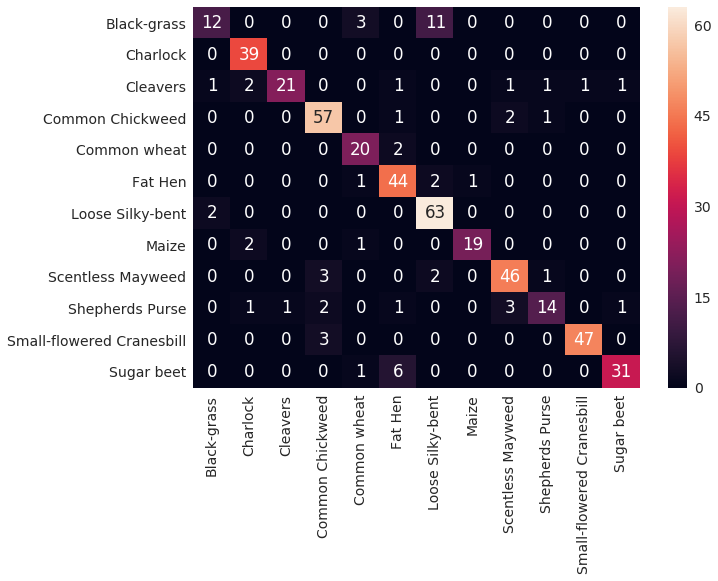

In [78]:
### heat map for confusion matrix
import seaborn as sn
df_cm = pd.DataFrame(array, index = category_list,
                  columns = category_list)
plt.figure(figsize = (10,7))
#sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, annot=True)# font size

In [67]:
### micro F1 score
from sklearn.metrics import  f1_score

MeanFScore_train = 100.0*f1_score(np.argmax(aug_train_label, axis=1), FCNN_RF.predict_classes(aug_VGG19_feature_train), average='micro') 
MeanFScore_valid = 100.0*f1_score(np.argmax(valid_label_one_hot, axis=1), FCNN_RF.predict_classes(VGG19_feature_valid), average='micro') 
MeanFScore_test = 100.0*f1_score(np.argmax(test_label_one_hot, axis=1), FCNN_RF.predict_classes(VGG19_feature_test), average='micro') 


448/475 [===========================>..] - ETA: 0s

In [68]:
print('MeanFScore for training data using CNN after refinement is: %.4f%%' % MeanFScore_train)
print('MeanFScore for valid data using CNN after refinement is: %.4f%%' % MeanFScore_valid)
print('MeanFScore for testing data using CNN after refinement is: %.4f%%' % MeanFScore_test)

MeanFScore for training data using CNN after refinement is: 92.5309%
MeanFScore for valid data using CNN after refinement is: 87.2515%
MeanFScore for testing data using CNN after refinement is: 86.9474%


In [85]:
### 5-fold cross validation, sampling method: stratified
from sklearn.model_selection import StratifiedKFold
#X = VGG19_feature_train
X = aug_VGG19_feature_train
#y = train_label_one_hot
y = aug_train_label
skf = StratifiedKFold(n_splits=5)
skf.get_n_splits(X, np.where(y == 1)[1])

MeanFScore_train_CV = []
MeanFScore_test_CV = []


for train_index, test_index in skf.split(X, np.where(y == 1)[1]):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    FCNN_CV = Sequential()
    FCNN_CV.add(GlobalAveragePooling2D(input_shape=X_train.shape[1:]))
    FCNN_CV.add(Dense(256, activation='relu'))
    FCNN_CV.add(Dropout(0.2))
    FCNN_CV.add(Dense(12, activation='softmax'))
    FCNN_CV.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
    
    FCNN_CV.fit(X_train, y_train, epochs=20, batch_size=32, verbose=1)

    FCNN_CV_predictions = [np.argmax(FCNN_CV.predict(np.expand_dims(feature, axis=0))) for feature in X_test]

    MeanFScore_train_CV.append(100.0*f1_score(np.argmax(y_test, axis=1), FCNN_CV.predict_classes(X_test), average='micro'))
    
    MeanFScore_test_CV.append(100.0*f1_score(np.argmax(test_label_one_hot, axis=1), FCNN_CV.predict_classes(VGG19_feature_test), average='micro')) 

Epoch 1/20
24620/24620 [==============================] - 8s - loss: 0.7891 - acc: 0.7372     
Epoch 2/20
24620/24620 [==============================] - 4s - loss: 0.3770 - acc: 0.8665     
Epoch 3/20
24620/24620 [==============================] - 4s - loss: 0.2883 - acc: 0.8963     
Epoch 4/20
24620/24620 [==============================] - 4s - loss: 0.2409 - acc: 0.9152     
Epoch 5/20
24620/24620 [==============================] - 4s - loss: 0.2040 - acc: 0.9265     
Epoch 6/20
24620/24620 [==============================] - 4s - loss: 0.1835 - acc: 0.9364     
Epoch 7/20
24620/24620 [==============================] - 4s - loss: 0.1651 - acc: 0.9438     
Epoch 8/20
24620/24620 [==============================] - 4s - loss: 0.1452 - acc: 0.9480     
Epoch 9/20
24620/24620 [==============================] - 4s - loss: 0.1376 - acc: 0.9538     
Epoch 10/20
24620/24620 [==============================] - 4s - loss: 0.1258 - acc: 0.9576     
Epoch 11/20
24620/24620 [========================

In [86]:
MeanFScore_test_CV

[85.89473684210527,
 88.0,
 85.26315789473685,
 84.21052631578947,
 86.73684210526315]

In [91]:
MeanFScore_train_CV

[88.08441558441558,
 84.58915232218253,
 85.0414162741595,
 85.88139723801788,
 85.78861788617887]